## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

Penjelasan: Library berikut diimpor untuk mendukung analisis data dan pembangunan model. Pandas digunakan untuk manipulasi data berbentuk tabel, sedangkan NumPy digunakan untuk operasi numerik. Seaborn dan Matplotlib berfungsi untuk visualisasi data. TensorFlow dipakai dalam pembuatan dan pelatihan model rekomendasi berbasis machine learning. Sementara itu, scikit-learn digunakan untuk ekstraksi fitur teks dengan TF-IDF, penerapan pemodelan berbasis jarak terdekat, serta pembagian dataset untuk pelatihan dan validasi model.

## Membaca Data

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

Penjelasan: Membaca tiga file CSV yang berisi data film, rating pengguna, dan tag yang diberikan pengguna untuk film:

movies.csv: Berisi ID film, judul, dan genre.
ratings.csv: Menyimpan data rating yang diberikan oleh pengguna terhadap film tertentu.
tags.csv: Menyimpan tag yang diberikan oleh pengguna untuk menggambarkan preferensi atau karakteristik penting dari film tersebut.

## Informasi Data

In [6]:
print("Jumlah film:", movies.shape)
print("Jumlah rating:", ratings.shape)
print("Jumlah tag:", tags.shape)

print("\nContoh data movies:")
print(movies.head())

print("\nContoh data ratings:")
print(ratings.head())

print("\nContoh data tags:")
print(tags.head())


Jumlah film: (9742, 3)
Jumlah rating: (100836, 4)
Jumlah tag: (3683, 4)

Contoh data movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Contoh data ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Contoh data tags:
   userId  movieId              tag   times

Penjelasan: Dataset memiliki:

- 9.742  film, yang menunjukkan keberagaman pilihan dalam koleksi data.
- 100.836 penilaian dari pengguna, menyediakan basis yang kuat untuk pengembangan model rekomendasi.
- 3.683 tag, yang dapat dimanfaatkan untuk memperkuat metode rekomendasi berbasis konten.
Ditampilkan juga contoh lima baris pertama dari setiap dataset untuk melihat struktur datanya.

In [7]:
print("Missing values pada data movies:")
print(movies.isnull().sum())

print("\nMissing values pada data ratings:")
print(ratings.isnull().sum())

print("\nMissing values pada data tags:")
print(tags.isnull().sum())

Missing values pada data movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values pada data ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values pada data tags:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


Penjelasan: Pemeriksaan terhadap missing values pada semua dataset menunjukkan bahwa tidak terdapat data yang kosong. Hal ini menandakan bahwa dataset sudah bersih dan siap untuk digunakan dalam analisis selanjutnya tanpa memerlukan proses pembersihan tambahan.

In [8]:
print("Jumlah data duplikat pada movies:", movies.duplicated().sum())
print("Jumlah data duplikat pada ratings:", ratings.duplicated().sum())
print("Jumlah data duplikat pada tags:", tags.duplicated().sum())

Jumlah data duplikat pada movies: 0
Jumlah data duplikat pada ratings: 0
Jumlah data duplikat pada tags: 0


Penjelasan: Pemeriksaan terhadap keberadaan data duplikat di ketiga dataset menunjukkan tidak adanya entri yang berulang. Dengan demikian, data yang digunakan bersifat unik dan bebas dari potensi bias akibat penggandaan informasi.

In [9]:
Q1 = ratings['rating'].quantile(0.25)
Q3 = ratings['rating'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ratings[(ratings['rating'] < lower_bound) | (ratings['rating'] > upper_bound)]
num_outliers = len(outliers)

print(f"Jumlah outlier: {num_outliers}")


Jumlah outlier: 4181


Penjelasan: Melalui analisis Interquartile Range (IQR), ditemukan sebanyak 4.181 rating yang tergolong sebagai outlier. Namun, nilai-nilai tersebut tetap dipertahankan karena masih masuk dalam batas yang dapat diterima dan menggambarkan preferensi individual pengguna secara autentik.

## Visualisasi Data

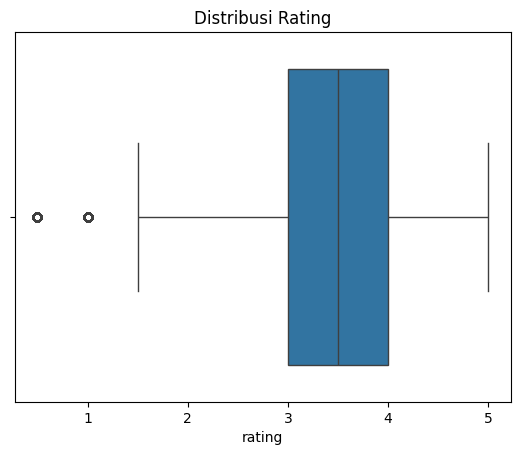

In [10]:
sns.boxplot(x=ratings['rating'])
plt.title('Distribusi Rating')
plt.show()

Penjelasan: Box plot menggambarkan bahwa sebagian besar rating berkisar antara 3 hingga 4, menunjukkan kecenderungan pengguna untuk memberikan penilaian positif terhadap film yang mereka saksikan.

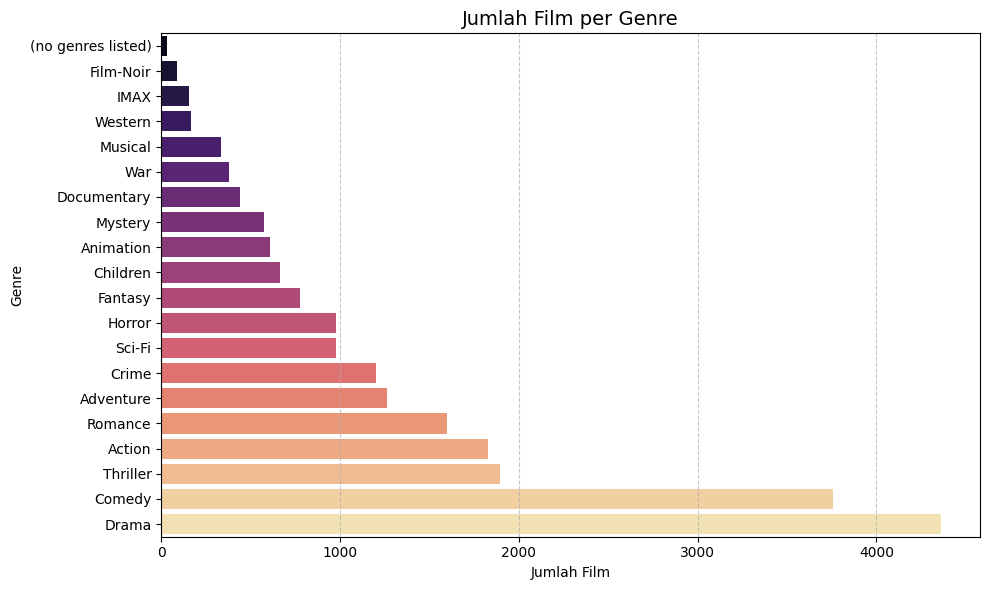

In [12]:
# Hitung jumlah film per genre
genre_matrix = movies['genres'].str.get_dummies(sep='|')
genre_totals = genre_matrix.sum().sort_values(ascending=True)

# Gaya visualisasi horizontal barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_totals.values, y=genre_totals.index, palette='magma')
plt.title('Jumlah Film per Genre', fontsize=14)
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Penjelasan: Diagram batang memperlihatkan bahwa genre Drama mendominasi dataset, diikuti oleh Comedy. Hal ini mengindikasikan bahwa kedua genre tersebut paling banyak tercatat dalam data dan kemungkinan besar menjadi favorit di kalangan pengguna.

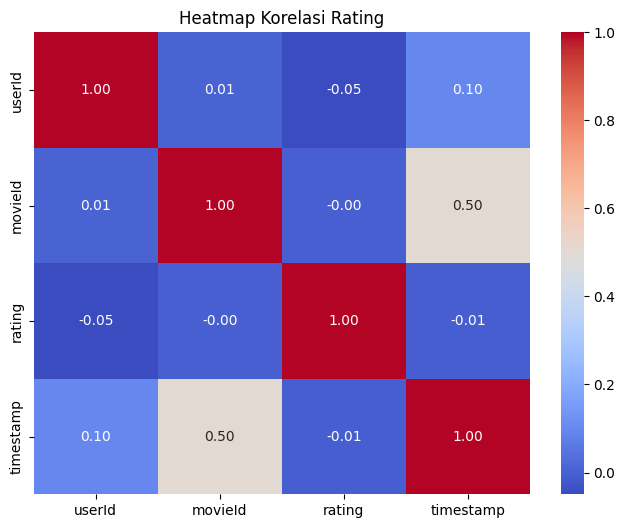

In [14]:
corr_matrix = ratings.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi Rating")
plt.show()

Penjelasan: Heatmap korelasi mengilustrasikan hubungan antar variabel dalam dataset rating. Terlihat korelasi tertinggi sebesar 0,50 antara movieId dan timestamp, yang mengindikasikan adanya pola tertentu dalam penilaian film berdasarkan waktu.

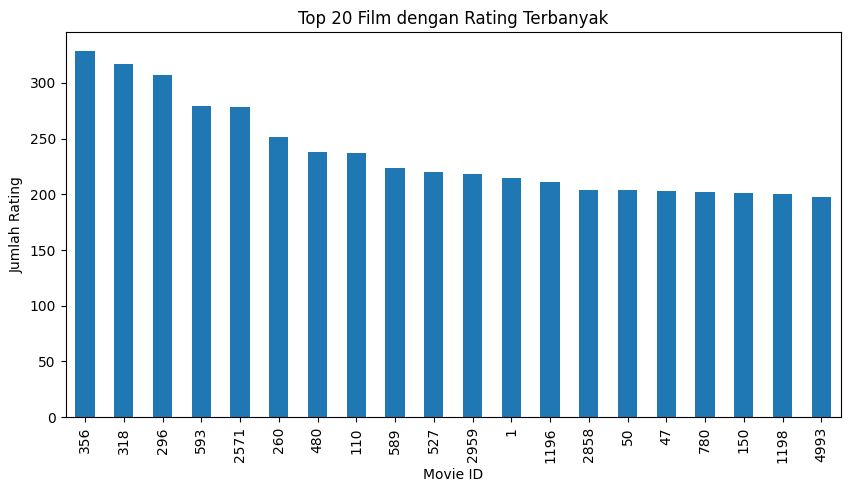

In [33]:
rating_counts = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
rating_counts.head(20).plot(kind='bar', figsize=(10,5))
plt.title('Top 20 Film dengan Rating Terbanyak')
plt.xlabel('Movie ID')
plt.ylabel('Jumlah Rating')
plt.show()

Penjelasan: Grafik batang ini menampilkan 20 film yang menerima jumlah rating terbanyak dari pengguna. Informasi ini berguna untuk mengidentifikasi film-film populer yang berpotensi menjadi prioritas dalam sistem rekomendasi berbasis popularitas.

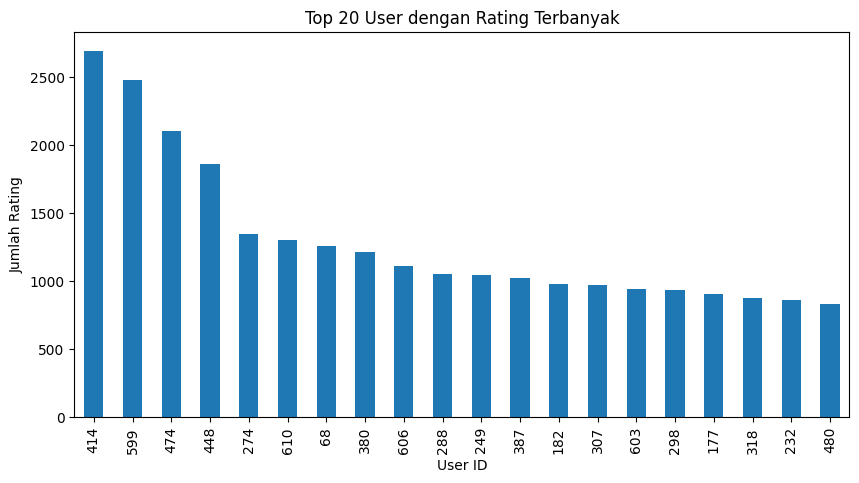

In [22]:
user_ratings = ratings.groupby('userId')['rating'].count().sort_values(ascending=False)
user_ratings.head(20).plot(kind='bar', figsize=(10,5))
plt.title('Top 20 User dengan Rating Terbanyak')
plt.xlabel('User ID')
plt.ylabel('Jumlah Rating')
plt.show()

Penjelasan: Visualisasi ini memperlihatkan 20 pengguna dengan jumlah rating terbanyak. Pengguna yang sangat aktif ini cenderung memiliki preferensi yang khas, sehingga informasinya dapat membantu memahami pola perilaku penonton dalam pengembangan sistem rekomendasi.

## Preprocessing Data (Content-Based Filtering)

In [23]:
tags_agg = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movies_with_tags = pd.merge(movies, tags_agg, on='movieId', how='left')

movies_with_tags['combined'] = movies_with_tags['genres'].fillna('') + ' ' + movies_with_tags['tag'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_with_tags['combined'])

title_to_index = pd.Series(movies_with_tags.index, index=movies_with_tags['title']).drop_duplicates()

Penjelasan:

- Tag dari setiap film digabungkan menjadi satu string per movieId, sehingga setiap film memiliki kumpulan tag dalam bentuk teks.
- Data film kemudian digabungkan dengan kumpulan tag tersebut untuk menambah informasi konteks film.
- Kolom baru bernama combined dibuat dengan menggabungkan genre dan tag menjadi satu teks representasi.
- Teks gabungan ini diproses menggunakan TF-IDF untuk mengubah kata-kata menjadi fitur numerik yang merefleksikan pentingnya setiap kata.
- Mapping title_to_index dibuat agar sistem rekomendasi dapat dengan mudah mengakses indeks berdasarkan judul film.

## Modeling & Rekomendasi (Content-Based Filltering)

In [24]:
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

def recommend_content(title, top_n=5):
    idx = title_to_index[title]
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=top_n + 1)
    indices = indices.flatten()[1:]
    return movies_with_tags.iloc[indices][['title', 'genres']]

print("Rekomendasi mirip Pinocchio:")
print(recommend_content("Pinocchio (1940)"))


Rekomendasi mirip Pinocchio:
                                      title  \
981                         Fantasia (1940)   
511  Snow White and the Seven Dwarfs (1937)   
780                       Cinderella (1950)   
789              Alice in Wonderland (1951)   
786                            Dumbo (1941)   

                                           genres  
981            Animation|Children|Fantasy|Musical  
511      Animation|Children|Drama|Fantasy|Musical  
780    Animation|Children|Fantasy|Musical|Romance  
789  Adventure|Animation|Children|Fantasy|Musical  
786              Animation|Children|Drama|Musical  


- Model Nearest Neighbors menggunakan metrik cosine similarity, cocok untuk mengukur kesamaan pada data teks karena menilai pola distribusi kata.
- Model ini dibangun dengan menggunakan matriks TF-IDF, yang mengubah genre dan tag film menjadi fitur numerik.
- Fungsi recommend_movies():
   - Mengambil indeks film berdasarkan judul.
Mencari film yang paling mirip menggunakan knn.kneighbors.
   - Mengambil n_neighbors terdekat, kecuali film yang diminta (karena film itu tidak perlu direkomendasikan ke dirinya sendiri).
   - Mengembalikan film yang paling relevan berdasarkan kemiripan teks.

## Preprocessing Data (Collaborative Filltering)

In [25]:
df = ratings.copy()

user_ids = df['userId'].unique().tolist()
movie_ids = df['movieId'].unique().tolist()

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

user_encoded_to_user = {i: x for x, i in user_to_user_encoded.items()}
movie_encoded_to_movie = {i: x for x, i in movie_to_movie_encoded.items()}

df['user'] = df['userId'].map(user_to_user_encoded)
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

min_rating = df['rating'].min()
max_rating = df['rating'].max()

df['rating_normalized'] = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

Penjelasan: Melakukan preprocessing data rating dengan meng-encode ID pengguna dan ID film, serta menormalisasi nilai rating.

## Pembagian Data Latih dan Validasi (Collaborative Filltering)

In [26]:
x = df[['user', 'movie']].values
y = df['rating_normalized'].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

Penjelasan: Membagi data rating menjadi data latih dan data validasi dengan rasio 80:20 dan menggunakan random_state untuk memastikan pembagian data yang konsisten.

## Model Rekomendasi Deep Learning (Collaborative Filltering)

In [27]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(num_movies, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

Penjelasan: Model rekomendasi berbasis deep learning dibuat menggunakan embedding untuk merepresentasikan interaksi antara pengguna dan film:

- Embedding layer digunakan untuk menyimpan representasi numerik pengguna dan film.
- Interaksi antara pengguna dan film dihitung dengan operasi dot product pada embedding tersebut.
- Aktivasi sigmoid diterapkan untuk mendapatkan nilai prediksi rating.

## Pelatihan Model (Collaborative Filltering)

In [28]:
num_users = len(user_to_user_encoded)
num_movies = len(movie_to_movie_encoded)

model = RecommenderNet(num_users, num_movies, embedding_size=50)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.6598 - root_mean_squared_error: 0.2557 - val_loss: 0.6200 - val_root_mean_squared_error: 0.2157
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6173 - root_mean_squared_error: 0.2129 - val_loss: 0.6170 - val_root_mean_squared_error: 0.2123
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.6095 - root_mean_squared_error: 0.2037 - val_loss: 0.6118 - val_root_mean_squared_error: 0.2070
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.6068 - root_mean_squared_error: 0.2010 - val_loss: 0.6117 - val_root_mean_squared_error: 0.2068
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.6088 - root_mean_squared_error: 0.2017 - val_loss: 0.6099 - val_root_mean_squared_error: 0.2049
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6075 - root_mean_squared_error: 0.2016 - val_loss: 0.6123 - val_root_mean_squared_error: 0.2073
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━

Penjelasan: Model dilatih menggunakan 10 epoch dengan batch size 64. Selama pelatihan, Root Mean Squared Error (RMSE) menunjukkan penurunan yang konsisten, mengindikasikan bahwa model semakin memahami pola rating pengguna.

In [29]:
train_rmse_last = history.history['root_mean_squared_error'][-1]
val_rmse_last = history.history['val_root_mean_squared_error'][-1]
print(f"Final RMSE - Train: {train_rmse_last:.4f}, Validation: {val_rmse_last:.4f}")

Final RMSE - Train: 0.1966, Validation: 0.2039


Penjelasan: Model menghasilkan nilai RMSE sebesar 0.1966 pada data pelatihan dan 0.2039 pada data validasi. Hasil ini menunjukkan model mampu memprediksi dengan akurat dan tidak menunjukkan tanda-tanda overfitting.

## Evaluasi Model (Collaborative Filltering)

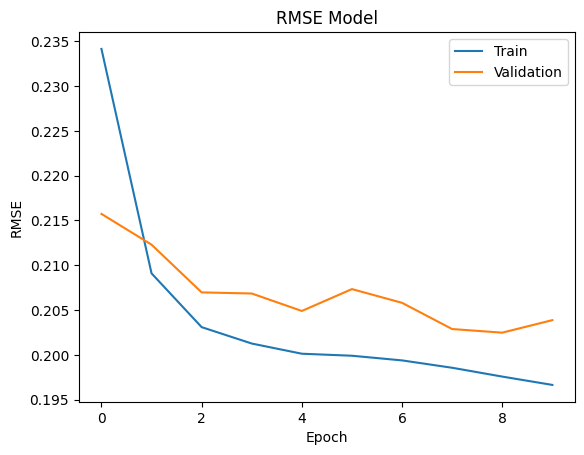

In [30]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE Model')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Penjelasan: Grafik RMSE memperlihatkan perubahan performa model sepanjang proses pelatihan. Terlihat bahwa setelah beberapa epoch, nilai RMSE stabil, yang menandakan pelatihan berjalan dengan baik dan model mulai konvergen.

## Rekomendasi Film (Collaborative Filltering)

In [31]:
user_id = 356
top_n = 10

encoded_user_id = user_to_user_encoded[user_id]

rated_movie_ids = df[df['userId'] == user_id]['movieId'].values
encoded_rated_movie_ids = [movie_to_movie_encoded[movie_id] for movie_id in rated_movie_ids]

all_movie_ids = set(range(num_movies))

not_rated_movie_ids = list(all_movie_ids - set(encoded_rated_movie_ids))

user_movie_array = np.hstack((
    np.full((len(not_rated_movie_ids), 1), encoded_user_id),
    np.array(not_rated_movie_ids).reshape(-1, 1)
))

predicted_ratings = model.predict(user_movie_array).flatten()

top_indices = predicted_ratings.argsort()[-top_n:][::-1]
top_movie_encoded_ids = [not_rated_movie_ids[i] for i in top_indices]
top_movie_ids = [movie_encoded_to_movie[i] for i in top_movie_encoded_ids]

print(f"Showing recommendations for user: {user_id}")
print("=" * 40)

print("Film dengan rating tertinggi dari user")
print("-" * 40)
top_rated_user_movies = (
    df[df['userId'] == user_id]
    .sort_values(by='rating', ascending=False)
    .head(5)['movieId']
    .values
)

top_rated_movies_info = movies[movies['movieId'].isin(top_rated_user_movies)]
for row in top_rated_movies_info.itertuples():
    print(f"{row.title} - Genre: {row.genres}")

print("-" * 40)
print(f"Top {top_n} film rekomendasi")
print("-" * 40)

recommended_movies = movies[movies['movieId'].isin(top_movie_ids)]
for row in recommended_movies.itertuples():
    print(f"{row.title} - Genre: {row.genres}")

295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Showing recommendations for user: 356
Film dengan rating tertinggi dari user
----------------------------------------
So I Married an Axe Murderer (1993) - Genre: Comedy|Romance|Thriller
Wallace & Gromit: The Best of Aardman Animation (1996) - Genre: Adventure|Animation|Comedy
Superbad (2007) - Genre: Comedy
Lars and the Real Girl (2007) - Genre: Comedy|Drama
Battlestar Galactica: Razor (2007) - Genre: Action|Drama|Sci-Fi|Thriller
----------------------------------------
Top 10 film rekomendasi
----------------------------------------
Star Wars: Episode IV - A New Hope (1977) - Genre: Action|Adventure|Sci-Fi
Pulp Fiction (1994) - Genre: Comedy|Crime|Drama|Thriller
Schindler's List (1993) - Genre: Drama|War
Godfather, The (1972) - Genre: Crime|Drama
Rear Window (1954) - Genre: Mystery|Thriller
Star Wars: Episode V - The Empire Strikes Back (1980) - Genre: Action|Adventure|Sci-Fi
Goodfellas (1990) - Genre: Crime|Drama
Boondock Saints, The (2000) -

Penjelasan: Berdasarkan prediksi model, ditampilkan:

1. 5 Film dengan rating tertinggi yang telah diberikan oleh pengguna.

2. 10 Film rekomendasi yang dipilih berdasarkan preferensi pengguna melalui model deep learning.

Struktur rekomendasi ini membantu memberikan rekomendasi yang lebih personal dan relevan bagi pengguna.